[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Mate_MercadosFinancieros/blob/main/Semana6_Black_Litterman.ipynb)

# Asignación de capital de Black-Litterman

## Recordemos un poco:

- ¿Recuerdan que haciamos en portafolios de Markowitz?

- ¿Que ventajas tenía dicho método?

- ¿Que desventajas tenía?




La clase de hoy se constituye por:

- Descargar datos para el método de Black-Litterman
- Construir un vector de retornos a priori
- Construir una matriz de incetidumbre
- Combinar Black-Litterman con optimizacion de tipo Markowitz



# Instalaciones necesarias

In [ ]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Descarga de datos

Tomaremos los precios de activos, pero también su capitalización de mercado(market-cap)


In [ ]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [ ]:
ohlc = yf.download(tickers, period="1y")
prices = ohlc["Adj Close"]
prices

[*********************100%%**********************]  10 of 10 completed


Ticker,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2023-08-24,131.839996,27.792717,516.607605,81.824600,374.240601,58.244312,275.797394,317.586182,3.767292,92.482864
2023-08-25,133.259995,27.676186,518.842346,82.707634,376.077942,58.515614,277.975647,320.573761,3.677595,93.116783
2023-08-28,133.139999,27.928671,520.960327,83.501373,383.516144,58.680344,277.096527,321.288391,3.560988,94.638168
2023-08-29,134.910004,28.326817,527.353577,83.739494,381.461548,58.622204,277.008636,325.963287,3.695535,96.695953
2023-08-30,135.070007,28.200577,526.858032,83.620430,389.383698,58.593140,277.643524,326.340485,3.596868,96.783707
...,...,...,...,...,...,...,...,...,...,...
2024-08-19,178.220001,39.669998,872.349976,90.820000,432.839996,68.980003,287.549988,421.529999,3.640000,92.300003
2024-08-20,178.880005,38.689999,876.200012,89.739998,427.059998,69.379997,285.630005,424.799988,3.600000,93.010002
2024-08-21,180.110001,38.750000,881.419983,90.720001,427.700012,69.570000,289.709991,424.140015,3.620000,92.779999


In [ ]:
prices.index

DatetimeIndex(['2023-08-24', '2023-08-25', '2023-08-28', '2023-08-29',
               '2023-08-30', '2023-08-31', '2023-09-01', '2023-09-05',
               '2023-09-06', '2023-09-07',
               ...
               '2024-08-12', '2024-08-13', '2024-08-14', '2024-08-15',
               '2024-08-16', '2024-08-19', '2024-08-20', '2024-08-21',
               '2024-08-22', '2024-08-23'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)

En algún momento, tomaremos un modo en que se siente el mercado, y el mejor indicador para eso son los precios del S&P500

In [ ]:
market_prices = yf.download("SPY", period="1y")["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2023-08-24,430.863373
2023-08-25,433.900879
2023-08-28,436.652405
2023-08-29,442.964081
2023-08-30,444.788574


Aquí obtenemos la capitalizacion del mercado, que se obtiene como:

$$ Market Cap = Precio \, del \, activo \,\, X \,\, Cantidad \, de \, acciones\, que\, hay\, en\, el\, mercado $$

In [ ]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 3098016743424,
 'AMZN': 1858140897280,
 'NAT': 757929472,
 'BAC': 308598505472,
 'DPZ': 14873402368,
 'DIS': 164238704640,
 'KO': 300785827840,
 'MCD': 207685124096,
 'COST': 389784567808,
 'SBUX': 106543456256}

# Construyendo las medias a Priori

In [ ]:
import pypfopt
pypfopt.__version__

'1.5.5'

In [ ]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

16.579611303747264

Aquí se calcula $\delta$, que es la compensación que tienen los inversores de acuerdo al riesgo que asumen:

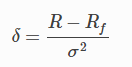

Esta se va a usar para calcular los retornos dado el mercado:

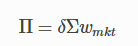

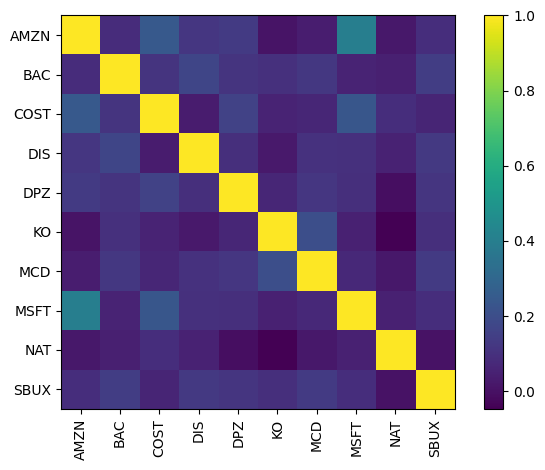

In [ ]:
plotting.plot_covariance(S, plot_correlation=True);

In [ ]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

,0
Ticker,
AMZN,0.597342
BAC,0.138601
COST,0.229571
DIS,0.153504
DPZ,0.141153
KO,0.073724
MCD,0.096306
MSFT,0.531775
NAT,0.063909


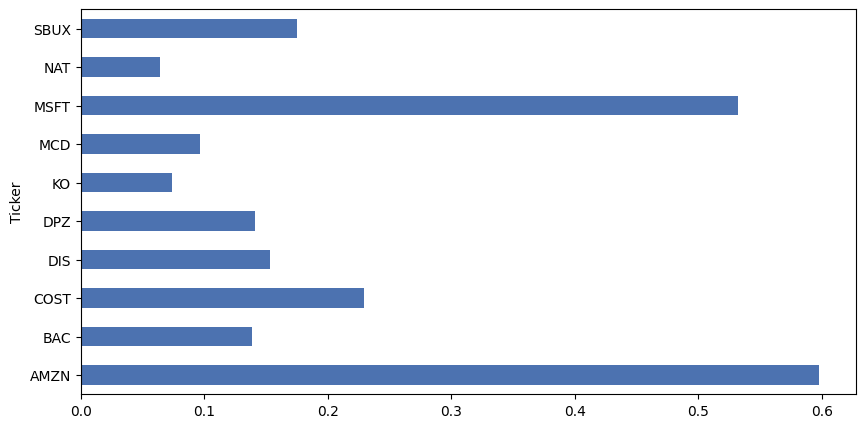

In [ ]:
market_prior.plot.barh(figsize=(10,5));

# Expectativas (Views)

En el método de BL, podemos incluir intuición de "expertos" (o de quien quieran) para crear nuestros portafolios.

Aquí los especificamos por medio de una matriz P (picking matrix) y un vector Q. Q contiene las magnitudes de cada "view", mientras que P hace el mapeo entre eso y el activo al que pertenece.

Si proveemos una "visión absoluta" (i.e. un retorno estimado para cada activo), no tenemos que preocuparnos por P y Q, podemos solo pasar la "visión" como un diccionario.

In [ ]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

# Confianza en la Visión

Aquí proveemos 2 maneras de construir la matriz de incertidumbre. La primera se conoce como el metodo de Idzorek. Este permite especificar una lista o vector de los porcentajes de confianza que tengamos.

In [ ]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7,
    0.5,
    0.1,
    0.4
]

In [ ]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

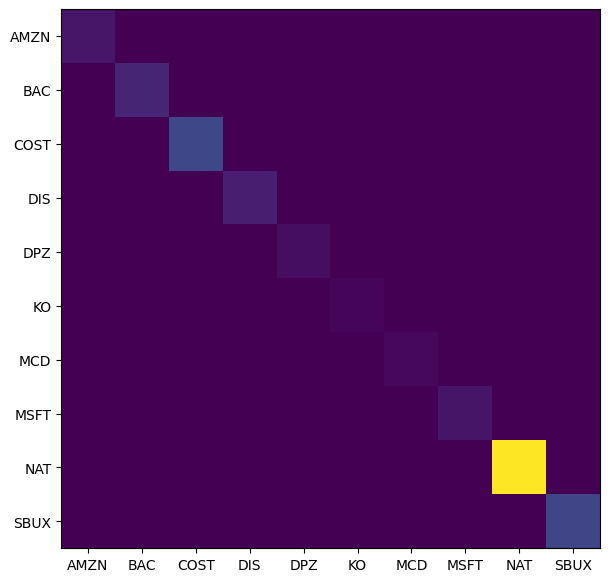

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [ ]:
np.diag(bl.omega)

array([0.00251631, 0.00440624, 0.00907694, 0.0034695 , 0.00161379,
       0.0006903 , 0.00088208, 0.00236487, 0.04208891, 0.00886056])

Nótese que NAT, a quien le dimos una baja confianza, tambien tiene la incertidumbre mas grande.

En lugar de poner directamente la confianza, podemos calcular la matriz de incertidumbre si especificamos directamente intervalos de confianza de 1 desviación estandar de tamaño, es decir, donde creemos que se encontrará el dato el 68% de las veces.

In [ ]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [ ]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


# Estimaciones a Posteriori

Dadas las entradas, podemos calcular los retornos a posteriori.

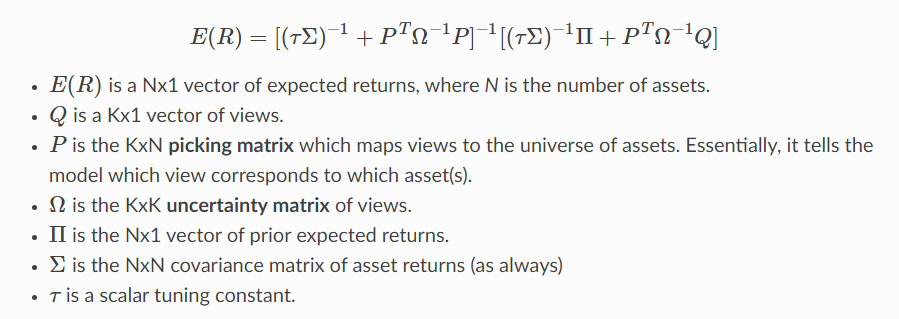

In [ ]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [ ]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

,0
Ticker,
AMZN,0.352863
BAC,0.119629
COST,0.122513
DIS,0.081926
DPZ,0.150111
KO,0.011905
MCD,0.094209
MSFT,0.157406
NAT,0.034794


We can visualise how this compares to the prior and our views:

In [ ]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.597342,0.352863,0.10
BAC,0.138601,0.119629,0.30
COST,0.229571,0.122513,0.05
DIS,0.153504,0.081926,0.05
DPZ,0.141153,0.150111,0.20
KO,0.073724,0.011905,-0.05
MCD,0.096306,0.094209,0.15
MSFT,0.531775,0.157406,0.10
NAT,0.063909,0.034794,0.50
SBUX,0.175435,0.111296,0.10


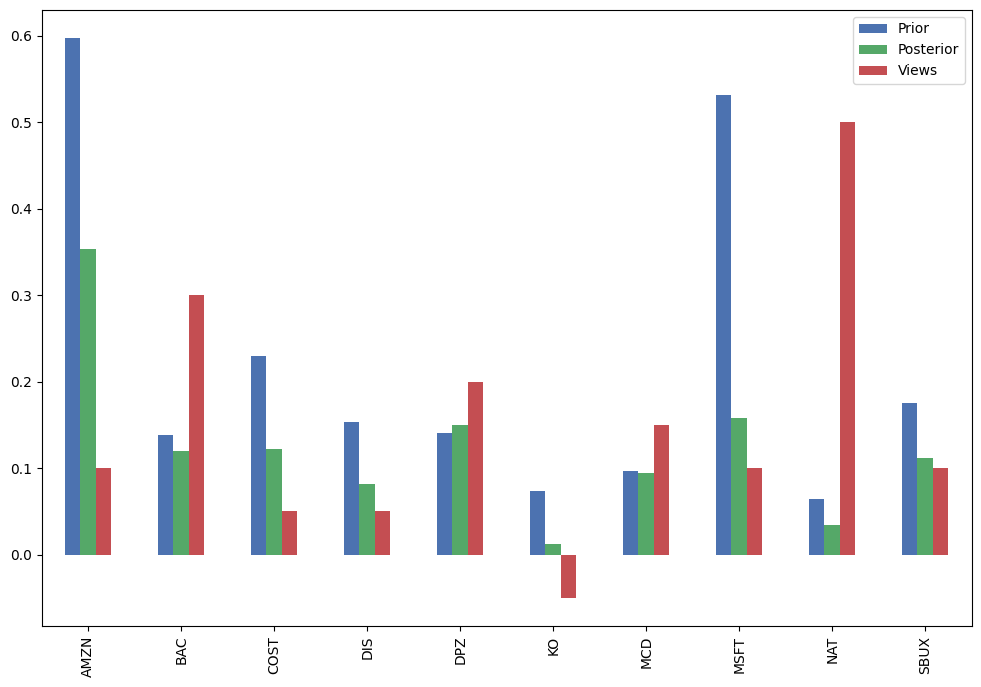

In [ ]:
rets_df.plot.bar(figsize=(12,8));

El método de BL termina siendo un promedio ponderado Bayesiano entre las estimaciones a priori y las estimaciones a posteriori, donde los pesos se determinan por la confianza que se tenga.

Un proceso similar puede ser usado para producir el estimado a posteriori de las covarianzas:

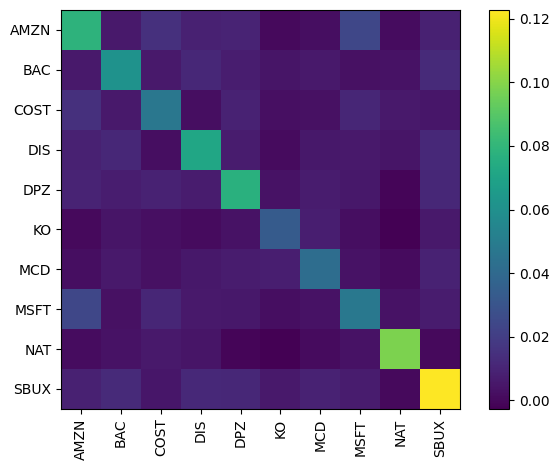

In [ ]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Asignación de pesos en el portafolio

Listo, tenemos mejoresw inputs que solo los valores históricos, podemos proceder con un método de optimización de media-varianza.

In [ ]:
from pypfopt import EfficientFrontier, objective_functions

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)

Como visto en Markowitz, podemos determinar un nivel de retorno mínimo

In [ ]:
np.set_printoptions(suppress=True)


In [ ]:
ef.efficient_return(0.25)

OrderedDict([('AMZN', 0.5233040863835787),
             ('BAC', 0.07011835806559),
             ('COST', 0.0715746912228044),
             ('DIS', 0.0),
             ('DPZ', 0.1265161105912079),
             ('KO', 0.0),
             ('MCD', 0.0220994308998686),
             ('MSFT', 0.1381603999523422),
             ('NAT', 0.0),
             ('SBUX', 0.0482269228846083)])

O buscar el punto que maximice la razón de Sharpe

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.32742),
             ('BAC', 0.0962),
             ('COST', 0.09776),
             ('DIS', 0.05596),
             ('DPZ', 0.1241),
             ('KO', 0.0),
             ('MCD', 0.07347),
             ('MSFT', 0.13157),
             ('NAT', 0.01259),
             ('SBUX', 0.08094)])

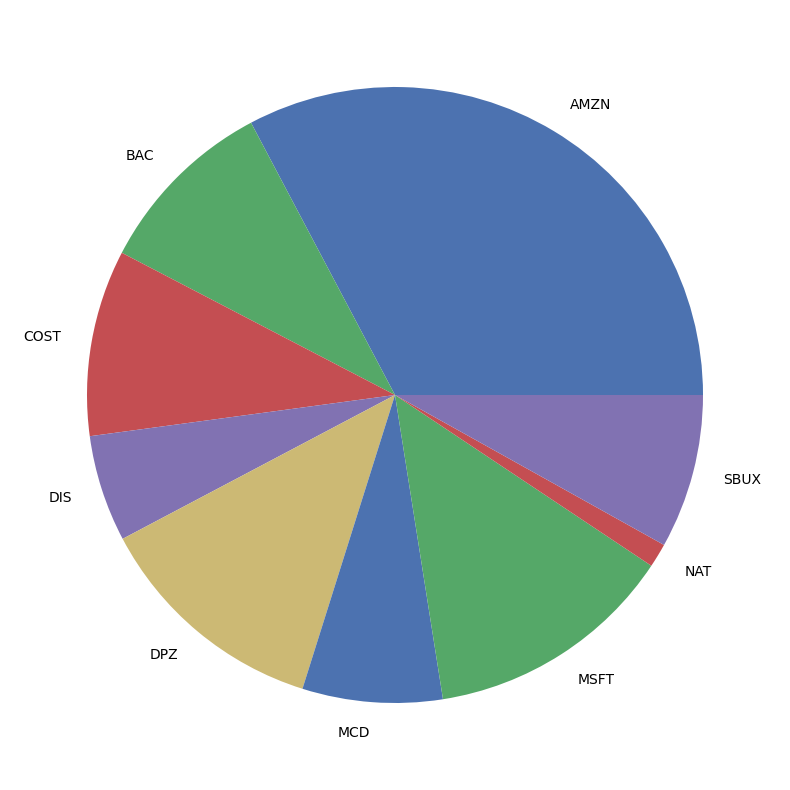

In [ ]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [ ]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $13.66


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AMZN': 37,
 'BAC': 51,
 'COST': 2,
 'DIS': 13,
 'DPZ': 6,
 'MCD': 5,
 'MSFT': 6,
 'NAT': 77,
 'SBUX': 18}

# Ejercicio: Agregue una matriz P y un vector de expectativas Q, donde agregaremos las expectativas relativas (no solo las absolutas) de pronosticos que crean que pueden pasar.

In [ ]:
# Espacio para ejercicios

# Referencias:

- [Docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html)

- [Github](https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
